In [43]:
# group comparisons
import pandas as pd
import ast
from collections import defaultdict
import numpy as np

In [44]:
# read right leaning results
right_leaning_stable_moderation = pd.read_csv('./results/right_flagged_stable.csv')
right_leaning_latest_moderation = pd.read_csv('./results/right_flagged_latest_March28th.csv')

In [45]:
# read left leaning results
left_leaning_stable_moderation = pd.read_csv('./results/left_flagged_stable.csv')
left_leaning_latest_moderation = pd.read_csv('./results/left_flagged_latest_March28th.csv')

In [46]:
def flagged_stats(group1, group2):
    group1_flagged = len(group1[group1['flagged_run'] == True])
    group2_flagged = len(group2[group2['flagged_run'] == True])
    return (group1_flagged/len(group1), group2_flagged/len(group2))

In [47]:
print(f"The stable moderation model flagged percentage (left, right) is: {flagged_stats(left_leaning_stable_moderation, right_leaning_stable_moderation)}")
print(f"The latest moderation model flagged percentage (left, right) is: {flagged_stats(left_leaning_latest_moderation, right_leaning_latest_moderation)}")

The stable moderation model flagged percentage (left, right) is: (0.1294883655977796, 0.12619986287281454)
The latest moderation model flagged percentage (left, right) is: (0.1293661738265226, 0.12622128899554336)


In [66]:
# Is the flagging between groups caused by the same classes
def compute_classwise(moderation_df, flagged=None):
    classwise_scores = defaultdict(list)
    for idx, row in moderation_df.iterrows():
        score = row['scores']
        score = ast.literal_eval(score)
        for k,v in score.items():
            if flagged == True:
                if row['flagged_run'] == True:
                    classwise_scores[k] += [v]
            elif flagged == False:
                if row['flagged_run'] == False:
                    classwise_scores[k] += [v]
            else:
                classwise_scores[k] += [v]
    classwise_scores = {k:np.mean(v) for k,v in classwise_scores.items()}
    return classwise_scores

In [68]:
# latest
left_classwise = compute_classwise(left_leaning_latest_moderation, flagged=True)
right_classwise = compute_classwise(right_leaning_latest_moderation, flagged=True)
classwise_difference_latest = {k:abs(right_classwise[k]-v)*100/(right_classwise[k] + v) for k,v in left_classwise.items()}
classwise_difference_latest

{'harassment': 0.11794360373452253,
 'harassment_threatening': 2.8740888327066694,
 'hate': 5.724494816237694,
 'hate_threatening': 4.445138587732773,
 'self_harm': 3.6988040457550024,
 'self_harm_instructions': 24.767689105201665,
 'self_harm_intent': 7.957812178135998,
 'sexual': 0.5639167185320122,
 'sexual_minors': 31.906583821482105,
 'violence': 5.793429434337773,
 'violence_graphic': 0.9000677801951099,
 'self-harm': 3.6988040457550024,
 'sexual/minors': 31.906583821482105,
 'hate/threatening': 4.445138587732773,
 'violence/graphic': 0.9000677801951099,
 'self-harm/intent': 7.957812178135998,
 'self-harm/instructions': 24.767689105201665,
 'harassment/threatening': 2.8740888327066694}

In [69]:
# stable
left_classwise = compute_classwise(left_leaning_stable_moderation, flagged=True)
right_classwise = compute_classwise(right_leaning_stable_moderation, flagged=True)
classwise_difference_stable = {k:abs(right_classwise[k]-v)*100/(right_classwise[k] + v) for k,v in left_classwise.items()}
classwise_difference_stable

{'harassment': 0.1461761253538473,
 'harassment_threatening': 2.663231300231996,
 'hate': 5.660355518073161,
 'hate_threatening': 4.169832347444636,
 'self_harm': 4.062843391669777,
 'self_harm_instructions': 25.735976629119232,
 'self_harm_intent': 7.411451236695181,
 'sexual': 0.6321777722017217,
 'sexual_minors': 31.977302963268723,
 'violence': 5.693510758456876,
 'violence_graphic': 0.9048915584366737,
 'self-harm': 4.062843391669777,
 'sexual/minors': 31.977302963268723,
 'hate/threatening': 4.169832347444636,
 'violence/graphic': 0.9048915584366737,
 'self-harm/intent': 7.411451236695181,
 'self-harm/instructions': 25.735976629119232,
 'harassment/threatening': 2.663231300231996}

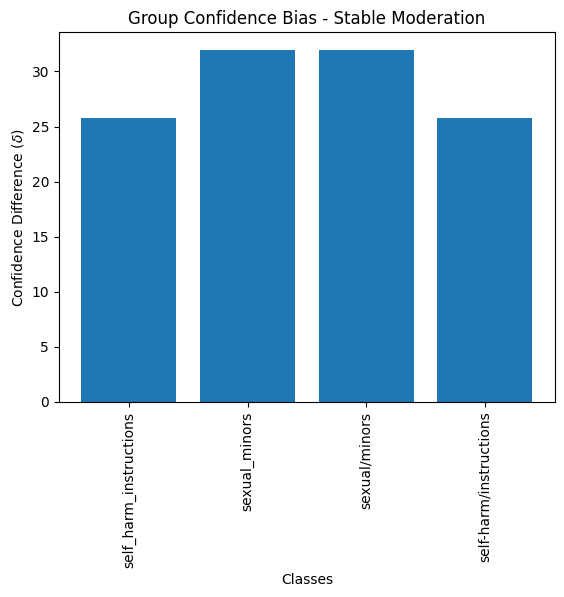

In [70]:
import matplotlib.pyplot as plt
classwise_to_display = {k:v for k,v in classwise_difference_stable.items() if v > 10}
plt.bar(*zip(*classwise_to_display.items()))
plt.xticks(rotation='vertical')
plt.xlabel('Classes')
plt.ylabel('Confidence Difference ($\delta$)')
plt.title('Group Confidence Bias - Stable Moderation')
plt.savefig('./results/stable_ideology_confdiff_flagged.png',dpi=300, bbox_inches = "tight")
plt.show()

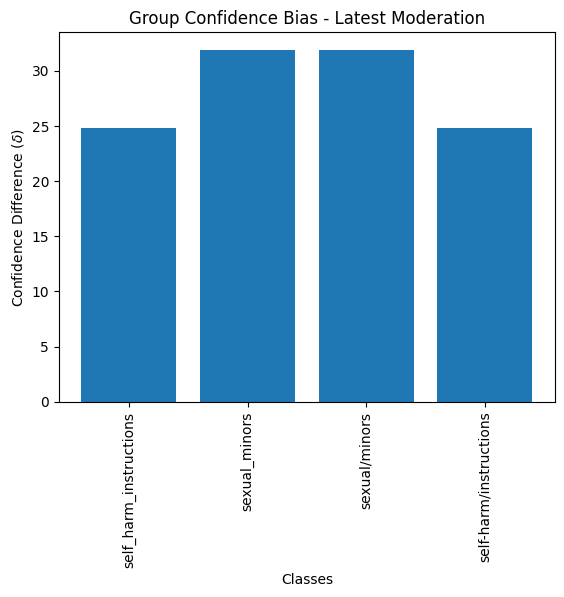

In [71]:
classwise_to_display = {k:v for k,v in classwise_difference_latest.items() if v > 10}
plt.bar(*zip(*classwise_to_display.items()))
plt.xticks(rotation='vertical')
plt.xlabel('Classes')
plt.ylabel('Confidence Difference ($\delta$)')
plt.title('Group Confidence Bias - Latest Moderation')
plt.savefig('./results/latest_ideology_confdiff_flagged.png', dpi=300, bbox_inches = "tight")
plt.show()